<a href="https://colab.research.google.com/github/AlejandroPinto5/EDA-projects/blob/main/NYC-taxi-project/Pred_taxi_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Prediction Taxi Trip Duration**

Here, I build Basic models such as decision tree and linear regression and see howthese models staack up against each ohter.

In [9]:
#Importing libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

In [8]:
# Loading data
df = pd.read_csv('drive/MyDrive/nyc_taxi_trip_duration.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


##Preprocessing and Feature Extraction

We can only feed numeric features as input to the model. So the task is to convert the feature in numeric form. The data must be ready for feeding into the model but before that is important to use the variableto do some feature engineering. Some ideas to create new variables are as follow:

**1. Difference between pick up and derop off latitude:** Will give an idea about the distance covered which could be predictive.

**2. difference between picku up and drop off longitude:** Will give an idea about distance covered which could ne predictive.

**3. Haversine distance between pick up and drop off coordinates:** to caputre the actual distance travelled.

**4. Pick up minute:** since pick up hour is important variable, the minute of pick up might well have been predictive.

**5. Pick up day of year:** since pick up hour is important variable, the minute of pick up might well have been predictive.


###DateTime Conversion

In [11]:
# Converting from string to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Adding datetime features
df.loc[:,'pickup_weekday'] = df['pickup_datetime'].dt.weekday
df.loc[:,'pickup_hour_weekofyear'] = df['pickup_datetime'].dt.weekofyear
df.loc[:,'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:,'pickup.minute'] = df['pickup_datetime'].dt.minute
df.loc[:,'pickup_dt'] = (df['pickup_datetime'] -df['pickup_datetime'].min()).dt.total_seconds()
df.loc[:,'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']

In [13]:
# Log transformation to log normal
df_y = np.log1p(df['trip_duration'])


###Distance Feature

In [14]:
#Calculating Euclidean Distance between pickup and drop off location
y_dist = df['pickup_longitude'] - df['dropoff_longitude']
x_dist = df['pickup_latitude'] - df['dropoff_latitude']
df['dist_sq'] = (y_dist ** 2) + (x_dist ** 2) #  Square distance
df['dist_sqrt'] = df['dist_sq'] ** 0.5 #   Distance

###Binning
The latitude and longitude could be a bit noisy and it might be a good idea to bin them and create new feature after rounding their values.



In [28]:
#   Binned coordiantes
df['pickup_lat_round3'] = np.round(df['pickup_latitude'], 3)
df['pickup_long_round3'] = np.round(df['pickup_longitude'], 3)
df['dropoff_lat_round3'] = np.round(df['dropoff_latitude'], 3)
df['dropoff_long_round3'] = np.round(df['dropoff_longitude'], 3)

###One hot encoding

In [30]:
#   Checking values
df.vendor_id.value_counts()

2    390481
1    338841
Name: vendor_id, dtype: int64

In [32]:
#   Converting 0 and 1 by subtracting 1from it
df['vendor_id'] = df['vendor_id'] - 1
np.sum(pd.isnull(df))

id                        0
vendor_id                 0
pickup_datetime           0
dropoff_datetime          0
passenger_count           0
pickup_longitude          0
pickup_latitude           0
dropoff_longitude         0
dropoff_latitude          0
store_and_fwd_flag        0
trip_duration             0
pickup_weekday            0
pickup_hour_weekofyear    0
pickup_hour               0
pickup.minute             0
pickup_dt                 0
pickup_week_hour          0
dist_sq                   0
dist_sqrt                 0
pickup_lat_round3         0
pickup_long_round3        0
dropoff_lat_round3        0
dropoff_long_round3       0
dtype: int64

In [33]:
df.fillna(0, inplace = True)

Before go on to build a model, it must drop the variables that should not be fed as features to the algorithms. It will drop:

id, pickup_datetime, dropoff_datetime, trip_duration, store_and_fwd_flag

In [34]:
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'store_and_fwd_flag'], axis = 1)

##Model Building


In [35]:
#   Checking dataset
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup.minute,pickup_dt,pickup_week_hour,dist_sq,dist_sqrt,pickup_lat_round3,pickup_long_round3,dropoff_lat_round3,dropoff_long_round3
0,0,1,-73.953918,40.778873,-73.963875,40.771164,0,9,16,40,5157547.0,16,0.000159,0.012592,40.779,-73.954,40.771,-73.964
1,-1,2,-73.988312,40.731743,-73.994751,40.694931,4,10,23,35,6132863.0,119,0.001397,0.037371,40.732,-73.988,40.695,-73.995
2,0,2,-73.997314,40.721458,-73.948029,40.774918,6,7,17,59,4471099.0,161,0.005287,0.072712,40.721,-73.997,40.775,-73.948
3,0,6,-73.961670,40.759720,-73.956779,40.780628,1,1,9,44,380597.0,33,0.000461,0.021473,40.760,-73.962,40.781,-73.957
4,-1,1,-74.017120,40.708469,-73.988182,40.740631,2,7,6,42,4084869.0,54,0.001872,0.043264,40.708,-74.017,40.741,-73.988


In [37]:
# squared metric
from sklearn.metrics import mean_squared_error
from math import sqrt

xtrain, xtest, ytrain, ytest = train_test_split(df, df_y, test_size = 1/3, random_state = 0) #   Splitting data

mean_pred = np.repeat(ytrain.mean(), len(ytest)) #   Mean prediction
sqrt(mean_squared_error(ytest, mean_pred))

0.7986672307875061

In [40]:
#   Cross Validation
def cv_score(ml_model, rstate = 11, cols = df.columns):
  i = 1
  cv_score = []
  df1 = df.copy()
  df1 = df[cols]

  kf = KFold(n_splits = 5, random_state = rstate, shuffle = True)
  for train_index, test_index in  kf.split(df1, df_y):
    print('\n{} of kfold{}'.format(i,kf.n_splits))
    xtr, xvl = df1.loc[train_index], df1.loc[test_index]
    ytr, yvl = df_y[train_index], df_y[test_index]

    model = ml_model
    model.fit(xtr, ytr)
    train_val = model.predict(xtr)
    pred_val = model.predict(xvl)
    rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
    rmse_score = sqrt(mean_squared_error(yvl, pred_val))
    sufix = ""
    msg = ""
    msg += "Valid RMSE: {:.5f}".format(rmse_score)
    print("{}".format(msg))
    cv_score.append(rmse_score)
    i+= 1
  return cv_score

In [41]:
#Linear regression
linreg_scores = cv_score(LinearRegression())


1 of kfold5
Valid RMSE: 0.62451

2 of kfold5
Valid RMSE: 0.62416

3 of kfold5
Valid RMSE: 0.76595

4 of kfold5
Valid RMSE: 0.72084

5 of kfold5
Valid RMSE: 0.61908


In [43]:
#   Decision Tree
dtree_scores = cv_score(DecisionTreeRegressor(min_samples_leaf = 25, min_samples_split = 25))


1 of kfold5
Valid RMSE: 0.44366

2 of kfold5
Valid RMSE: 0.44457

3 of kfold5
Valid RMSE: 0.43715

4 of kfold5
Valid RMSE: 0.44153

5 of kfold5
Valid RMSE: 0.43947


In [68]:
results_df = pd.DataFrame({'KFolds': [0,1,2,3,4], 'linear_regression': linreg_scores, 'dtree': dtree_scores})
results_df.head()

,KFolds,linear_regression,dtree
0,0,0.624512,0.443657
1,1,0.624164,0.444575
2,2,0.765948,0.437149
3,3,0.720841,0.441529
4,4,0.619083,0.439471


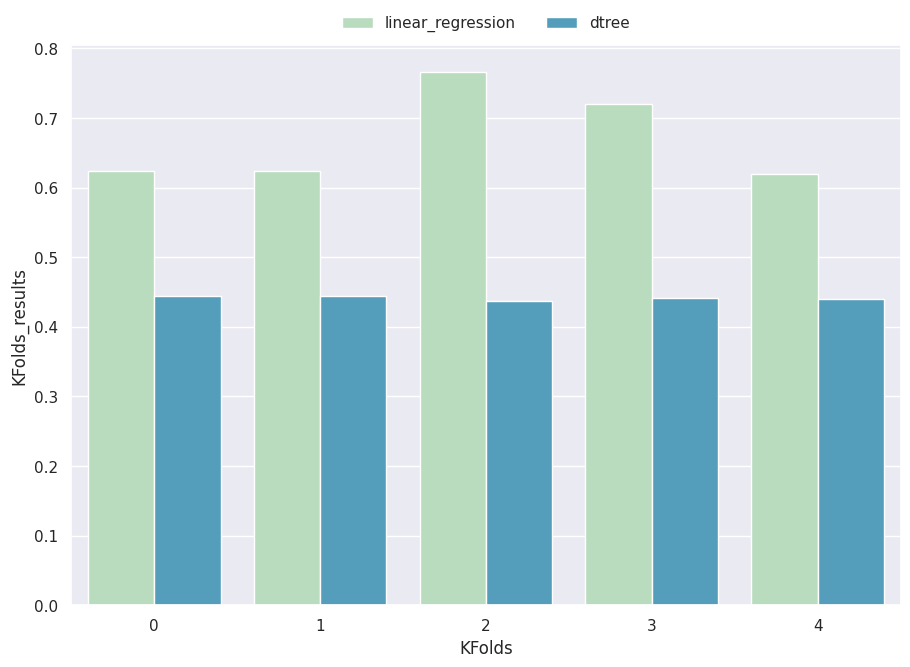

In [78]:
sb.set(rc={'figure.figsize':(10.7,7.27)})
fig = sb.barplot(data=results_df.melt("KFolds", var_name="model", value_name="KFolds_results"),
            x="KFolds",
            y="KFolds_results",
            hue="model",
            palette = "GnBu")
sb.move_legend(
    fig, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False,
)

A lot of imporvement. The reason for this could be the non linear relationship between trip duration values and location coordinates of pick up and drop off points. DEcision tree is performing much better than linera regression.

##Decision Tree Visulaization

In [79]:
from sklearn import tree
dtree = DecisionTreeRegressor(min_samples_leaf = 25, min_samples_split = 25)
dtree.fit(xtrain, ytrain)

DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)

In [81]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


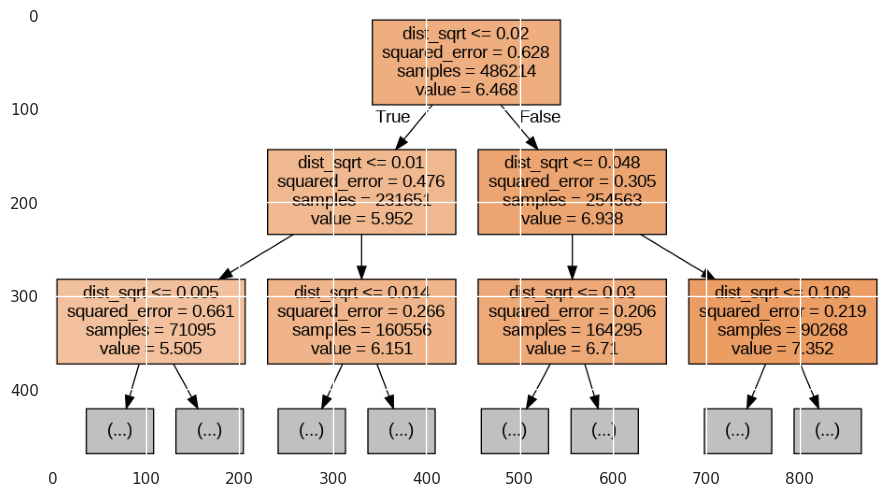

In [87]:
decision_tree = tree.export_graphviz(dtree, out_file = 'tree1.dot', feature_names = xtrain.columns, max_depth = 2, filled = True)
!dot -Tpng tree.dot -o tree1.png


img = plt.imread('tree1.png')
plt.imshow(img)
     

**Conclusion:** the extra features addedare adding a lotof value to rhe decision ree leraning indicating the additional features carry good value and are very important to the model.